### Imports/Meshcat Initialization:

In [1]:
from IPython.display import display, SVG
import numpy as np
import os
import pydot
import sys
import matplotlib.pyplot as plt

import pydrake
from pydrake.all import (
    Adder, AddMultibodyPlantSceneGraph, Demultiplexer, DiagramBuilder, 
    InverseDynamicsController, MakeMultibodyStateToWsgStateSystem, 
    MeshcatVisualizerCpp, MultibodyPlant,Parser, PassThrough, 
    SchunkWsgPositionController, StateInterpolatorWithDiscreteDerivative,
    RigidTransform, RotationMatrix, Simulator, SpatialVelocity, ConstantVectorSource,
    LogVectorOutput, DirectCollocation, MultibodyPositionToGeometryPose, 
    PiecewisePolynomial, SceneGraph, Solve, TrajectorySource
)

from manipulation.meshcat_cpp_utils import StartMeshcat
from manipulation.scenarios import AddIiwa, AddWsg, AddRgbdSensors
from manipulation.utils import FindResource
from manipulation import running_as_notebook
from manipulation.scenarios import AddShape

if running_as_notebook and sys.platform == "linux" and os.getenv("DISPLAY") is None:
    from pyvirtualdisplay import Display
    virtual_display = Display(visible=0, size=(1400, 900))
    virtual_display.start()

# Start the visualizer.
meshcat = StartMeshcat()

Meshcat is now available at https://94a9bd61-ed58-4c78-95db-bc94494e48ba.deepnoteproject.com


### Helper Functions:

In [5]:
def MakeManipulationStation(time_step=0.002):
    builder = DiagramBuilder()

    # Add (only) the iiwa, WSG, cameras, ball, and ground to the scene.
    plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=time_step)
    iiwa = AddIiwa(plant)
    wsg = AddWsg(plant, iiwa)
    #Parser(plant).AddModelFromFile(FindResource("models/camera_box.sdf"), "camera0")
    ball = AddShape(plant, pydrake.geometry.Sphere(0.03), name="ball", mu=0.2)

    ground = AddShape(plant, pydrake.geometry.Box(10,10,2.0), name="ground", mu=0.2)
    plant.WeldFrames(plant.world_frame(), plant.GetFrameByName("ground"), RigidTransform(p=[0,0,-1.0]))
    
    plant.Finalize()

    num_iiwa_positions = plant.num_positions(iiwa)

    # I need a PassThrough system so that I can export the input port.
    iiwa_position = builder.AddSystem(PassThrough(num_iiwa_positions))
    builder.ExportInput(iiwa_position.get_input_port(), "iiwa_position")
    builder.ExportOutput(iiwa_position.get_output_port(), "iiwa_position_command")

    # Export the iiwa "state" outputs.
    demux = builder.AddSystem(Demultiplexer(2 * num_iiwa_positions, num_iiwa_positions))
    builder.Connect(plant.get_state_output_port(iiwa), demux.get_input_port())
    builder.ExportOutput(demux.get_output_port(0), "iiwa_position_measured")
    builder.ExportOutput(demux.get_output_port(1), "iiwa_velocity_estimated")
    builder.ExportOutput(plant.get_state_output_port(iiwa), "iiwa_state_estimated")

    # Make the plant for the iiwa controller to use.
    controller_plant = MultibodyPlant(time_step=time_step)
    controller_iiwa = AddIiwa(controller_plant)
    AddWsg(controller_plant, controller_iiwa, welded=True)
    controller_plant.Finalize()

    # Add the iiwa controller
    iiwa_controller = builder.AddSystem(
        InverseDynamicsController(
            controller_plant,
            kp=[100]*num_iiwa_positions,
            ki=[1]*num_iiwa_positions,
            kd=[20]*num_iiwa_positions,
            has_reference_acceleration=False))
    iiwa_controller.set_name("iiwa_controller")
    builder.Connect(
        plant.get_state_output_port(iiwa), iiwa_controller.get_input_port_estimated_state())

    # Add in the feed-forward torque
    adder = builder.AddSystem(Adder(2, num_iiwa_positions))
    builder.Connect(iiwa_controller.get_output_port_control(), adder.get_input_port(0))

    # Use a PassThrough to make the port optional (it will provide zero values if not connected).
    torque_passthrough = builder.AddSystem(PassThrough([0]*num_iiwa_positions))
    builder.Connect(torque_passthrough.get_output_port(), adder.get_input_port(1))
    builder.ExportInput(torque_passthrough.get_input_port(), "iiwa_feedforward_torque")
    builder.Connect(adder.get_output_port(), plant.get_actuation_input_port(iiwa))

    # Add discrete derivative to command velocities.
    desired_state_from_position = builder.AddSystem(
        StateInterpolatorWithDiscreteDerivative(num_iiwa_positions, time_step, suppress_initial_transient=True))
    desired_state_from_position.set_name("desired_state_from_position")
    builder.Connect(desired_state_from_position.get_output_port(), iiwa_controller.get_input_port_desired_state())
    builder.Connect(iiwa_position.get_output_port(), desired_state_from_position.get_input_port())

    # Export commanded torques.
    #builder.ExportOutput(adder.get_output_port(), "iiwa_torque_commanded")
    #builder.ExportOutput(adder.get_output_port(), "iiwa_torque_measured")

    # Wsg controller.
    wsg_controller = builder.AddSystem(SchunkWsgPositionController())
    wsg_controller.set_name("wsg_controller")
    builder.Connect(wsg_controller.get_generalized_force_output_port(), plant.get_actuation_input_port(wsg))
    builder.Connect(plant.get_state_output_port(wsg), wsg_controller.get_state_input_port())
    builder.ExportInput(wsg_controller.get_desired_position_input_port(), "wsg_position")
    builder.ExportInput(wsg_controller.get_force_limit_input_port(), "wsg_force_limit")
    wsg_mbp_state_to_wsg_state = builder.AddSystem(MakeMultibodyStateToWsgStateSystem())
    builder.Connect(plant.get_state_output_port(wsg), wsg_mbp_state_to_wsg_state.get_input_port())
    builder.ExportOutput(wsg_mbp_state_to_wsg_state.get_output_port(), "wsg_state_measured")
    builder.ExportOutput(wsg_controller.get_grip_force_output_port(), "wsg_force_measured")

    # Cameras.
    #AddRgbdSensors(builder, plant, scene_graph)

    # Export "cheat" ports.
    builder.ExportOutput(scene_graph.get_query_output_port(), "geometry_query")
    builder.ExportOutput(plant.get_contact_results_output_port(), "contact_results")
    builder.ExportOutput(plant.get_state_output_port(), "plant_continuous_state")
    builder.ExportOutput(plant.get_state_output_port(iiwa), "iiwa_state")
    builder.ExportOutput(plant.get_state_output_port(ball), "ball_state")

    diagram = builder.Build()
    return diagram, plant

def MakeManipulationStationSimulation():
    diagram, plant = MakeManipulationStation()

    builder = DiagramBuilder()
    station = builder.AddSystem(diagram)

    MeshcatVisualizerCpp.AddToBuilder(builder, station.GetOutputPort("geometry_query"), meshcat)

    #fix wsg position
    wsg_position = builder.AddSystem(ConstantVectorSource([0.1]))
    builder.Connect(wsg_position.get_output_port(), station.GetInputPort("wsg_position"))

    #export iiwa position
    builder.ExportInput(station.GetInputPort("iiwa_position"))

    #attach loggers to iiwa and ball
    iiwa_logger = LogVectorOutput(station.GetOutputPort("iiwa_state"), builder, publish_period=0.1)
    ball_logger = LogVectorOutput(station.GetOutputPort("ball_state"), builder, publish_period=0.1)


    diagram = builder.Build()
    context = diagram.CreateDefaultContext()
    diagram.Publish(context)

    simulator = Simulator(diagram)
    context = simulator.get_mutable_context()
    plant_context = plant.GetMyContextFromRoot(context)

    return simulator, context, plant, plant_context, iiwa_logger, ball_logger


def show_diagram(diagram):
    display(SVG(pydot.graph_from_dot_data(diagram.GetGraphvizString())[0].create_svg()))


def predict_ball_trajectory(p_i, v_i, t, g=-9.81):
    """Predict ball position given inital position, velocity, and time.
    Neglects ball spin, only CoM motion is considered."""
    px_i, py_i, pz_i = p_i
    vx_i, vy_i, vz_i = v_i
    
    px_t = px_i + (vx_i*t)
    py_t = py_i + (vy_i*t)
    pz_t = pz_i + (vz_i*t) + (0.5*g*t**2)

    vx_t = vx_i
    vy_t = vy_i
    vz_t = vz_i + t*g

    p_t = [px_t, py_t, pz_t]
    v_t = [vx_t, vy_t, vz_t]
    return p_t, v_t

#### A few notes on the manipulation station:
##### iiwa
- The iiwa's state vector is 14-dimensional. The first 7 elements are joint positions, and the last 7 elements are joint velocities.

##### ball
- The ball's state vector is 13-dimensional. The first 7 elements are positions, and the last 6 elements are velocities.
- The first 4 elements of the position vector are a quaternion representation of the rotation of the ball. The remaining 3 are (x,y, z) of the ball in the world frame.
- The first 3 elements of the velocity vector are the rotational velocities (think of spin). The last three are the translational velocities of the ball in the world frame. 

##### plant
- There are 14 bodies in the plant. The 0th is the world, but you can peep the rest of them in the controls tab of meshcat.

## Experiment 1 -  Verify Forward Dynamics of Ball

### Directly Set iiwa/Ball State and Simulate:

In [8]:
simulator, context, plant, plant_context, iiwa_logger, ball_logger = MakeManipulationStationSimulation()

#initial condition
X_W_ball_initial = RigidTransform(RotationMatrix.MakeXRotation(0), [1, 1, 1])
V_W_ball_initial = SpatialVelocity([0,0,0,0,0,10]) # of the form w_x, w_y, w_z, v_x, v_y, v_z

ball = plant.GetBodyByName("ball")
plant.SetFreeBodyPose(plant_context, ball, X_W_ball_initial)
plant.SetFreeBodySpatialVelocity(body=ball, context=plant_context,  V_WB=V_W_ball_initial)

simulator.set_target_realtime_rate(0.25)
simulator.AdvanceTo(0.01);

In [9]:
#run after previous cell executes to prevent time-warping to end of trajectory
simulator.AdvanceTo(3);

#read from the loggers
iiwa_logger_context = iiwa_logger.GetMyContextFromRoot(context)
ball_logger_context = ball_logger.GetMyContextFromRoot(context)

iiwa_log = iiwa_logger.GetLog(iiwa_logger_context).data()
ball_log = ball_logger.GetLog(ball_logger_context).data()
time_log = np.linspace(0, 0.1*iiwa_log.shape[1], iiwa_log.shape[1]) # log points are 0.1s apart

### Compare forward dynamics against simulation output:

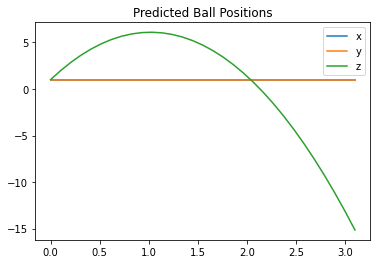

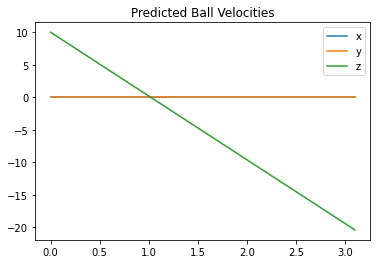

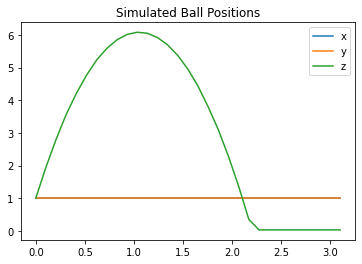

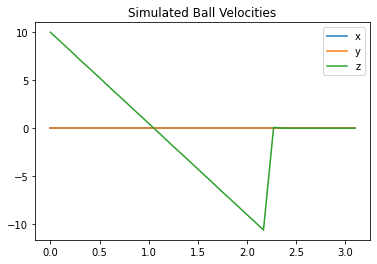

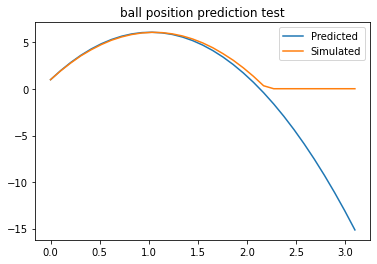

In [10]:
# run forward dynamics on ball
time_step = 0.1
run_time = 3.1
steps = int(run_time/time_step)
t_predicted = np.linspace(0, run_time, steps)
p_predicted = np.zeros((3, steps))
v_predicted = np.zeros((3, steps))

for i in range(steps):
    p_t, v_t = predict_ball_trajectory(X_W_ball_initial.translation(), V_W_ball_initial.translational(), t_predicted[i])
    p_predicted[:,i] = p_t
    v_predicted[:,i] = v_t


# plot predicted ball positions and velocities
for i, axis in enumerate(['x', 'y', 'z']):
    plt.plot(t_predicted, p_predicted[i], label=axis)
plt.title("Predicted Ball Positions")
plt.legend()
plt.show()

for i, axis in enumerate(['x', 'y', 'z']):
    plt.plot(t_predicted, v_predicted[i], label=axis)
plt.title("Predicted Ball Velocities")
plt.legend()
plt.show()


# plot simulated ball positions and velocities
t_simulated = time_log
p_simulated = ball_log[4:7, :]
v_simulated = ball_log[10:13, :]

for i, axis in enumerate(['x', 'y', 'z']):
    plt.plot(t_simulated, p_simulated[i], label=axis)
plt.title("Simulated Ball Positions")
plt.legend()
plt.show()

for i, axis in enumerate(['x', 'y', 'z']):
    plt.plot(t_simulated, v_simulated[i], label= axis) # translational component
plt.title("Simulated Ball Velocities")
plt.legend()
plt.show()


# compare z components:
plt.plot(t_predicted, p_predicted[2], label = 'Predicted')
plt.plot(t_simulated, p_simulated[2], label = 'Simulated')
plt.title("ball position prediction test")
plt.legend()
plt.show()

## Experiment 2 - Motion Planning via Trajectory Optimization

### Define Cost

In [11]:
# a significant amount of the code here came from this example notebook:
# https://github.com/RobotLocomotion/drake/blob/master/tutorials/mathematical_program_multibody_plant.ipynb

# construct plant
plant_f = MultibodyPlant(time_step = 0)
iiwa = AddIiwa(plant_f)
W = plant_f.world_frame()
L0 = plant_f.GetFrameByName("iiwa_link_0", iiwa)
L7 = plant_f.GetFrameByName("iiwa_link_7", iiwa)
#wsg = AddWsg(plant_f, iiwa)
plant_f.Finalize()

nq = plant_f.num_positions()
nu = plant_f.num_actuators()
context_f = plant_f.CreateDefaultContext()
plant_ad = plant_f.ToAutoDiffXd()
context_ad = plant_ad.CreateDefaultContext()

def resolve_frame(plant, F):
    """Gets a frame from a plant whose scalar type may be different."""
    return plant.GetFrameByName(F.name(), F.model_instance())

def link_7_distance_to_target(vars):
    """Evaluates squared distance between L7 origin and target."""

    q = vars[:nq]
    times = vars[nq:]
    time = sum(times)

    # Calculate target position.
    p_i = [0.5, 0.5, 0]
    v_i = [0, 0, 10]
    p_WT, v_WT = predict_ball_trajectory(p_i, v_i, time, g=-7)

    # Choose plant and context based on dtype.
    if q.dtype == float:
        plant = plant_f
        context = context_f
    else:
        # Assume AutoDiff.
        plant = plant_ad
        context = context_ad
    
    # Do forward kinematics.
    plant.SetPositions(context, iiwa, q)
    X_WL7 = plant.CalcRelativeTransform(context, resolve_frame(plant, W), resolve_frame(plant, L7))
    p_TL7 = X_WL7.translation() - p_WT
    return p_TL7.dot(p_TL7)

# WARNING: If you return a scalar for a constraint, or a vector for
# a cost, you may get the following cryptic error:
# "Unable to cast Python instance to C++ type"
#link_7_distance_to_target_vector = lambda q: [link_7_distance_to_target(q)]

### Formulate Optimization

In [12]:
dircol = DirectCollocation( 
    plant_f,
    context_f,
    num_time_samples=21,
    minimum_timestep=0.1,
    maximum_timestep=1,
    input_port_index = plant.get_input_port(3).get_index())

dircol.AddEqualTimeIntervalsConstraints()

# set initial state
initial_state = tuple([0]*14)
dircol.AddBoundingBoxConstraint(initial_state, initial_state, dircol.initial_state())

# extract decision variables
u = dircol.input()
x = dircol.state()
t = dircol.time()

# joint position and velocity constraints
pos_lower_limits = plant_f.GetPositionLowerLimits().tolist()
pos_upper_limits = plant_f.GetPositionUpperLimits().tolist()
vel_lower_limits = (plant_f.GetVelocityLowerLimits() ).tolist()
vel_upper_limits = (plant_f.GetVelocityUpperLimits() ).tolist()

for i in range(nq):
    dircol.AddConstraintToAllKnotPoints(pos_lower_limits[i] <= x[i])
    dircol.AddConstraintToAllKnotPoints(pos_upper_limits[i] >= x[i])
    dircol.AddConstraintToAllKnotPoints(vel_lower_limits[i] <= x[i+nq])
    dircol.AddConstraintToAllKnotPoints(vel_upper_limits[i] >= x[i+nq])

# joint torque constraints
torque_lower_limit = -100
torque_upper_limit = 100
for i in range(nu):
    dircol.AddConstraintToAllKnotPoints(torque_lower_limit <= u[i])
    dircol.AddConstraintToAllKnotPoints(torque_upper_limit >= u[i])

# add cost at every knot point
for i in range(20):
    state = dircol.state(i)[:nq]
    times = np.squeeze(np.array([dircol.timestep(j) for j in range(i+1)]))
    vars = np.append(state, times)

    dircol.AddCost(link_7_distance_to_target, vars=vars)

# set initial guess
#initial_x_trajectory = PiecewisePolynomial.FirstOrderHold([0., 4.], np.column_stack((initial_state, final_state)))  # yapf: disable
#dircol.SetInitialTrajectory(PiecewisePolynomial(), initial_x_trajectory)

result = Solve(dircol)
print("Success? ", result.is_success())
print('optimal cost = ', result.get_optimal_cost())
print('solver is: ', result.get_solver_id().name())

if(not result.is_success()):
    print(dircol)
    infeasible_constraints = result.GetInfeasibleConstraints(dircol)
    for c in infeasible_constraints:
        print(f"infeasible constraint: {c}")

assert result.is_success()

Success?  True
optimal cost =  325.4520285036916
solver is:  SNOPT/fortran


### Visualize Trajectory in Simulation

In [13]:
x_trajectory = dircol.ReconstructStateTrajectory(result)

plant = MultibodyPlant(time_step = 0)
scene_graph = SceneGraph()
plant.RegisterAsSourceForSceneGraph(scene_graph)
iiwa = AddIiwa(plant)
#wsg = AddWsg(plant, iiwa)
plant.Finalize()

builder = DiagramBuilder()
source = builder.AddSystem(TrajectorySource(x_trajectory))
builder.AddSystem(scene_graph)
pos_to_pose = builder.AddSystem(MultibodyPositionToGeometryPose(plant, input_multibody_state=True))
builder.Connect(source.get_output_port(0), pos_to_pose.get_input_port())
builder.Connect(pos_to_pose.get_output_port(), scene_graph.get_source_pose_port(plant.get_source_id()))

visualizer = MeshcatVisualizerCpp.AddToBuilder(builder, scene_graph.get_query_output_port(), meshcat)

diagram = builder.Build()
#display(SVG(pydot.graph_from_dot_data(diagram.GetGraphvizString())[0].create_svg())) # display diagram

simulator = Simulator(diagram)
simulator.set_target_realtime_rate(0.1)
simulator.AdvanceTo(0.01);

In [14]:
#run after previous cell executes to prevent time-warping to end of trajectory
simulator.AdvanceTo(4);

KeyboardInterrupt: 

### Plot iiwa Trajectory

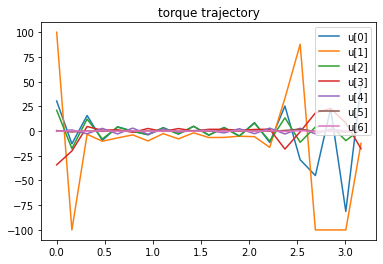

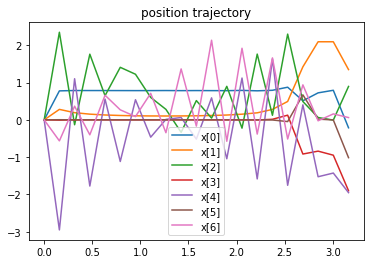

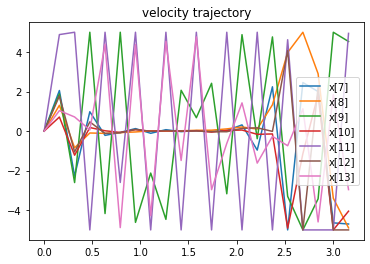

In [ ]:
x_trajectory = dircol.ReconstructStateTrajectory(result)
u_trajectory = dircol.ReconstructInputTrajectory(result)
t_trajectory = dircol.GetSampleTimes(result)

xs = np.zeros((len(t_trajectory), 14))
us = np.zeros((len(t_trajectory), 7))

for i, t in enumerate(t_trajectory):
    xs[i,:] = x_trajectory.value(t).T
    us[i,:] = u_trajectory.value(t).T

for i in range(7):
    plt.plot(t_trajectory, us[:,i], label=f'u[{i}]')
plt.legend()
plt.title('torque trajectory')
plt.show()

for i in range(7):
    plt.plot(t_trajectory, xs[:,i], label=f'x[{i}]')
plt.legend()
plt.title('position trajectory')
plt.show()

for i in range(7, 14):
    plt.plot(t_trajectory, xs[:,i], label=f'x[{i}]')
plt.legend()
plt.title('velocity trajectory')
plt.show()

### Compare with Ball Trajectory

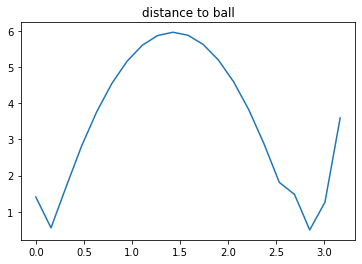

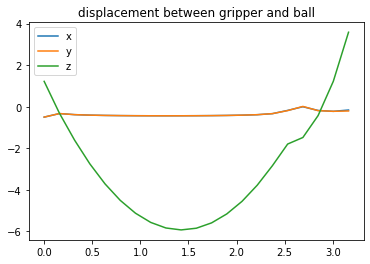

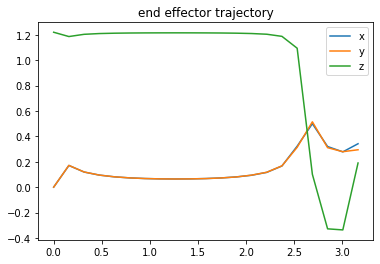

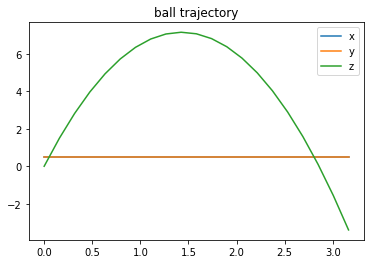

In [ ]:
plant_f = MultibodyPlant(time_step = 0)
iiwa = AddIiwa(plant_f)
W = plant_f.world_frame()
L0 = plant_f.GetFrameByName("iiwa_link_0", iiwa)
L7 = plant_f.GetFrameByName("iiwa_link_7", iiwa)


plant_f.Finalize()
context_f = plant_f.CreateDefaultContext()
plant_ad = plant_f.ToAutoDiffXd()
context_ad = plant_ad.CreateDefaultContext()

def reconstruct_end_effector_position(xs):
    frames = []
    for x in xs:
        q = x[:7]

        # Choose plant and context based on dtype.
        if q.dtype == float:
            plant = plant_f
            context = context_f
        else:
            # Assume AutoDiff.
            plant = plant_ad
            context = context_ad

        # Do forward kinematics.
        plant.SetPositions(context, iiwa, q)
        X_WL7 = plant.CalcRelativeTransform(context, resolve_frame(plant, W), resolve_frame(plant, L7))
        frames.append(X_WL7)
    
    return frames

def reconstruct_ball_position(ts):
    frames = []
    for time in ts:
        g = -7
        px_i = 0.5
        py_i = 0.5
        pz_i = 0
        vx_i = 0
        vy_i = 0
        vz_i = 10

        px_t = px_i + (vx_i*time)
        py_t = py_i + (vy_i*time)
        pz_t = pz_i + (vz_i*time) + (0.5*g*time**2)
        p_WT = RigidTransform(RotationMatrix.MakeXRotation(0), [px_t, py_t, pz_t])
        frames.append(p_WT)

    return frames

end_effector_trajectory = reconstruct_end_effector_position(xs)
ball_trajectory = reconstruct_ball_position(t_trajectory)

end_effector_trajectory_translational = np.array( [i.translation() for i in end_effector_trajectory] )
ball_trajectory_translational = np.array( [i.translation() for i in ball_trajectory] )
displacement = end_effector_trajectory_translational - ball_trajectory_translational

distance = np.linalg.norm(displacement, axis=1)

plt.plot(t_trajectory, distance)
plt.title('distance to ball')
plt.show()

plt.plot(t_trajectory, displacement[:,0], label = 'x')
plt.plot(t_trajectory, displacement[:,1], label = 'y')
plt.plot(t_trajectory, displacement[:,2], label = 'z')
plt.legend()
plt.title('displacement between gripper and ball')
plt.show()


plt.plot(t_trajectory, end_effector_trajectory_translational[:,0], label='x')
plt.plot(t_trajectory, end_effector_trajectory_translational[:,1], label='y')
plt.plot(t_trajectory, end_effector_trajectory_translational[:,2], label='z')
plt.legend()
plt.title('end effector trajectory')
plt.show()

plt.plot(t_trajectory, ball_trajectory_translational[:,0], label='x')
plt.plot(t_trajectory, ball_trajectory_translational[:,1], label='y')
plt.plot(t_trajectory, ball_trajectory_translational[:,2], label='z')
plt.legend()
plt.title('ball trajectory')
plt.show()

## Experiment 3 - Use Trajectory Optimization to Grab Ball

In [16]:
from pydrake.all import VectorSystem
class Policy(VectorSystem):

    def __init__(self):
        # 4 inputs: ball bot state [q, q_dot]
        # 1 output: control torque [u]
        VectorSystem.__init__(self, 0,  9)
       

    def DoCalcVectorOutput(self, context, state, unused, torque):
        torque[:] = context.get_time()

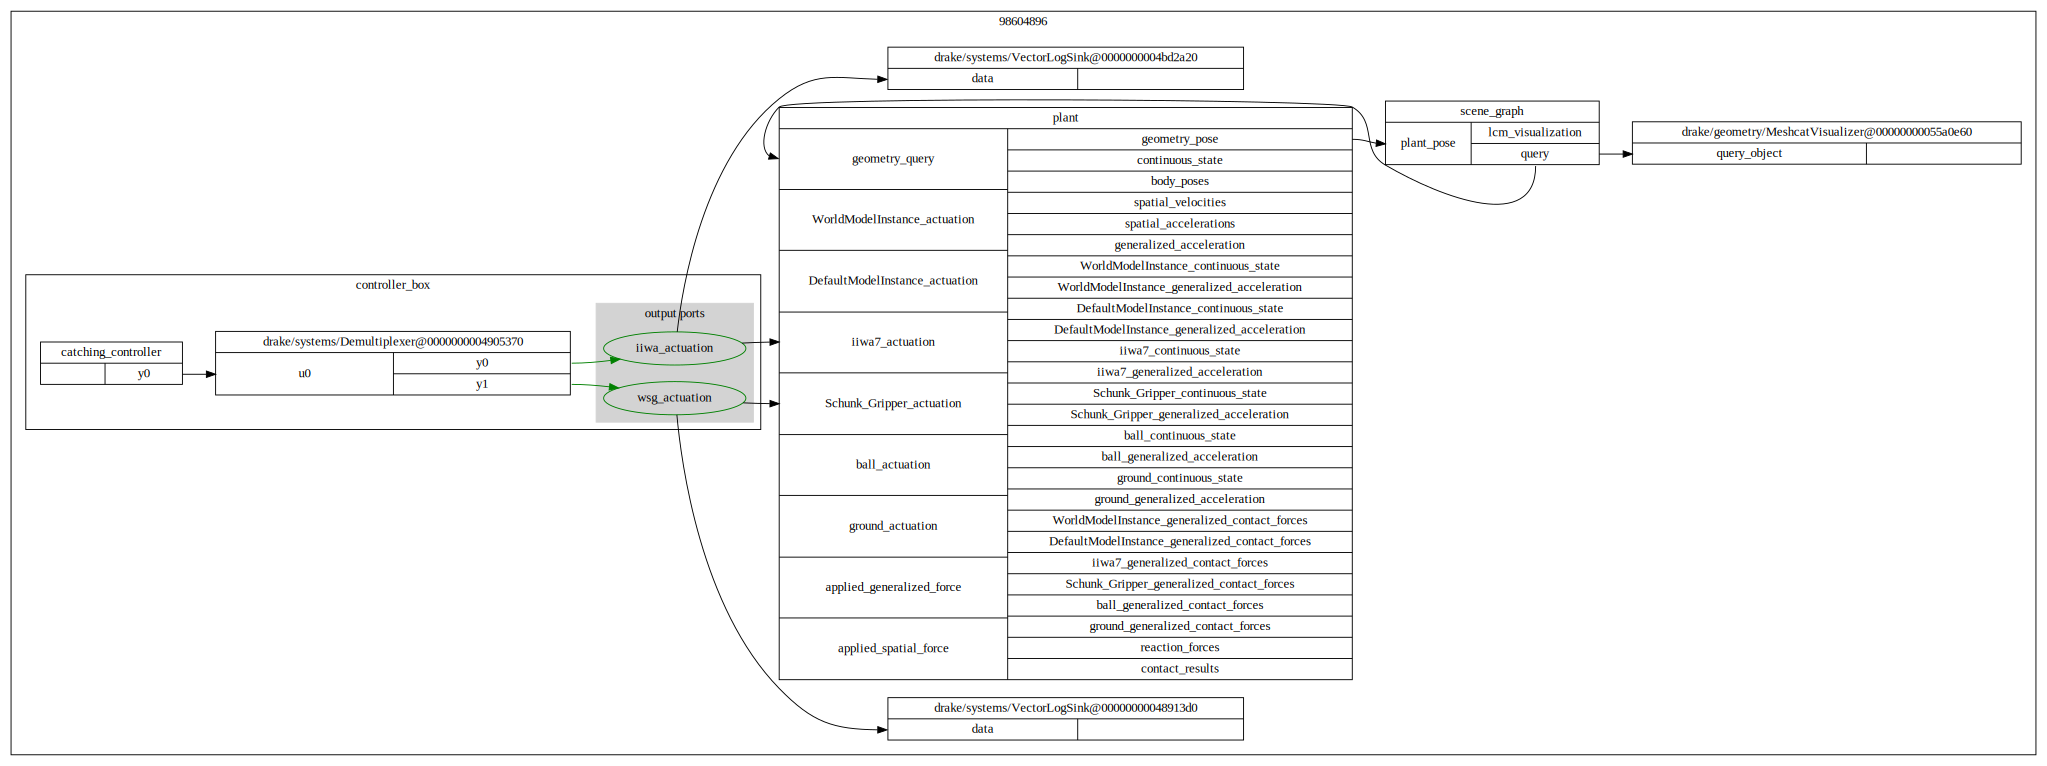

In [55]:
def MakeController():
    builder = DiagramBuilder()
    catching_controller = Policy()
    catching_controller.set_name("catching_controller")
    station = builder.AddSystem(catching_controller)

    demux = builder.AddSystem(Demultiplexer([7, 2]))

    builder.Connect(catching_controller.get_output_port(), demux.get_input_port())
    builder.ExportOutput(demux.get_output_port(0), "iiwa_actuation")
    builder.ExportOutput(demux.get_output_port(1), "wsg_actuation")
    diagram = builder.Build()
    diagram.set_name("controller_box")
    return diagram

def MakeControllerSimulator():
    # make diagram
    builder = DiagramBuilder()

    # add controller
    controller = MakeController()
    builder.AddSystem(controller) # controller? i don't even know her 

    # add loggers
    iiwa_actuation_logger = LogVectorOutput(controller.GetOutputPort("iiwa_actuation"), builder, publish_period=0.1)
    wsg_actuation_logger = LogVectorOutput(controller.GetOutputPort("wsg_actuation"), builder, publish_period=0.1)

    # build plant by adding iiwa, wsg, ball, and ground
    plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=time_step)
    iiwa = AddIiwa(plant)
    wsg = AddWsg(plant, iiwa)
    #Parser(plant).AddModelFromFile(FindResource("models/camera_box.sdf"), "camera0")
    ball = AddShape(plant, pydrake.geometry.Sphere(0.03), name="ball", mu=0.2)
    ground = AddShape(plant, pydrake.geometry.Box(10,10,2.0), name="ground", mu=0.2)
    plant.WeldFrames(plant.world_frame(), plant.GetFrameByName("ground"), RigidTransform(p=[0,0,-1.0]))
    
    plant.Finalize()

    # add visualizer
    MeshcatVisualizerCpp.AddToBuilder(builder, scene_graph.get_query_output_port(), meshcat)

    # connect controller to plant
    builder.Connect(controller.GetOutputPort("iiwa_actuation"), plant.get_input_port(3))
    builder.Connect(controller.GetOutputPort("wsg_actuation"), plant.get_input_port(4))

    # finish the diagram, make simulation
    diagram = builder.Build()
    context = diagram.CreateDefaultContext()
    diagram.Publish(context)

    simulator = Simulator(diagram)
    context = simulator.get_mutable_context()
    return simulator, context, diagram, iiwa_actuation_logger, wsg_actuation_logger

simulator, context, diagram, iiwa_actuation_logger, wsg_actuation_logger = MakeControllerSimulator()
show_diagram(diagram)

In [56]:
simulator.set_target_realtime_rate(1)
simulator.AdvanceTo(0.001);

In [57]:
simulator.AdvanceTo(1);

In [54]:
#read from the loggers
iiwa_actuation_logger_context = iiwa_actuation_logger.GetMyContextFromRoot(context)
wsg_actuation_logger_context = wsg_actuation_logger.GetMyContextFromRoot(context)

iiwa_log = iiwa_actuation_logger.GetLog(iiwa_actuation_logger_context).data()
wsg_log = wsg_actuation_logger.GetLog(wsg_actuation_logger_context).data()
wsg_log

array([[0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       [0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]])

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=94a9bd61-ed58-4c78-95db-bc94494e48ba' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>